## Image classification (16 classes) with pretrained model inceptiondeep

In [1]:
import PIL.Image as Image
import os

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image


### ImageDataGenerator and Data Augmentation


In [2]:
# Create ImageDataGenerator + Data Augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)


In [3]:
# Setting the default parameters
img_shape = (224, 224, 3)
img_size = (224, 224)
batch_size = 32


In [4]:
# Data upload and splitting into train and validation sets
training_data = datagen.flow_from_directory(
    'data/veg_16_classes/train',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

valid_data = datagen.flow_from_directory(
    'data/veg_16_classes/train',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')


Found 1139 images belonging to 16 classes.
Found 275 images belonging to 16 classes.


In [5]:
# Extracting the number of categories
categ_count = training_data.num_classes
print(f"There are {categ_count} categories")

There are 16 categories


In [6]:
class_names = training_data.class_indices
class_names = list(class_names.keys())
class_names

['cabbage',
 'capsicum',
 'carrot',
 'cauliflower',
 'chilli pepper',
 'cucumber',
 'eggplant',
 'garlic',
 'ginger',
 'lettuce',
 'onion',
 'peas',
 'potato',
 'spinach',
 'sweetcorn',
 'tomato']

### Builing the model

In [7]:
# load pre-trained InceptionV3
base_model = InceptionV3(
    weights='imagenet', include_top=False, input_shape=img_shape, pooling='avg')

# Freezing/ Unfreezing the layers
for layer in base_model.layers[:-15]:
    layer.trainable = False

for layer in base_model.layers[-15:]:
    layer.trainable = True


In [8]:
# Insert the base_model into the model to fit and compile
x = base_model.output
x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(categ_count, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy', metrics=['accuracy'])


In [9]:
early_stopping = EarlyStopping(
    monitor='val_accuracy', patience=5, restore_best_weights=True)


In [11]:
# Fit the model
step_size_train = training_data.n // training_data.batch_size
step_size_valid = valid_data.n // valid_data.batch_size

history = model.fit_generator(training_data,
                              steps_per_epoch=step_size_train,
                              validation_data=valid_data,
                              validation_steps=step_size_valid,
                              epochs=20,
                              verbose=1
                             )


/var/folders/_d/423mlwpd6h5c2sqfcynjvjgw0000gp/T/ipykernel_41004/3444606684.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(training_data,


Epoch 1/20
35/35 [==============================] - 35s 1s/step - loss: 0.4857 - accuracy: 0.8464 - val_loss: 0.4163 - val_accuracy: 0.8672
Epoch 2/20
35/35 [==============================] - 35s 982ms/step - loss: 0.4184 - accuracy: 0.8799 - val_loss: 0.2800 - val_accuracy: 0.9180
Epoch 3/20
35/35 [==============================] - 34s 957ms/step - loss: 0.2609 - accuracy: 0.9178 - val_loss: 0.3253 - val_accuracy: 0.9023
Epoch 4/20
35/35 [==============================] - 34s 979ms/step - loss: 0.2429 - accuracy: 0.9250 - val_loss: 0.2611 - val_accuracy: 0.9219
Epoch 5/20
35/35 [==============================] - 35s 982ms/step - loss: 0.2124 - accuracy: 0.9350 - val_loss: 0.2756 - val_accuracy: 0.9258
Epoch 6/20
35/35 [==============================] - 35s 999ms/step - loss: 0.1733 - accuracy: 0.9431 - val_loss: 0.2739 - val_accuracy: 0.9023
Epoch 7/20
35/35 [==============================] - 34s 985ms/step - loss: 0.1961 - accuracy: 0.9413 - val_loss: 0.2210 - val_accuracy: 0.9297
Ep

### Plotting the results


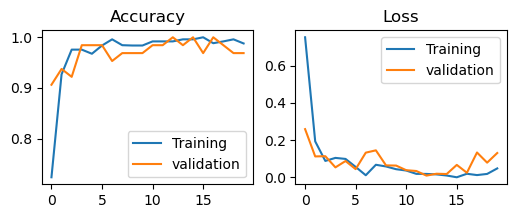

In [11]:
# Plot the Accuracy and Loss between Training and Validations sets

plt.figure(figsize=(6, 2))

plt.subplot(1, 2, 1)
plt.plot(history.epoch, history.history['accuracy'], label='Training')
plt.plot(history.epoch, history.history['val_accuracy'], label='validation')

plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.epoch, history.history['loss'], label='Training')
plt.plot(history.epoch, history.history['val_loss'], label='validation')

plt.title("Loss")
plt.legend()
plt.show()


### Saving the model

In [15]:
# Save the model
folder_path = 'models/'

model_name = 'inception_16cl_20ep.h5'
model.save(os.path.join(folder_path, model_name), save_format='h5')

### Checking the model

In [13]:
def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')  # Open image in RGB format
    # Resize the image to match the model's input size
    image = image.resize((224, 224))
    image_array = tf.keras.preprocessing.image.img_to_array(
        image)  # Convert image to numpy array
    image_array = image_array / 255.0  # Normalize image array
    return image_array


def predict_image(image_path, model):
    preprocessed_image = preprocess_image(image_path)
    preprocessed_image = tf.expand_dims(
        preprocessed_image, axis=0)  # Add batch dimension
    predictions = model.predict(preprocessed_image)
    predicted_class = tf.argmax(predictions[0]).numpy()
    predicted_class_name = class_names[predicted_class]
    return predicted_class_name


In [14]:
root = '/Users/G/Desktop/Documents/Formazione in Data Science/WBS/WBS Bootcamp/10. Final Project/data'
for i in range(1, 8):
    image_path = root + f'/testing_images/tomato/Image_{i}.jpg'
    predicted_class = predict_image(image_path, model)
    print('Predicted class:', predicted_class)

1/1 [==============================] - 0s 475ms/step
Predicted class: tomato
1/1 [==============================] - 0s 40ms/step
Predicted class: tomato
1/1 [==============================] - 0s 41ms/step
Predicted class: tomato
1/1 [==============================] - 0s 43ms/step
Predicted class: tomato
1/1 [==============================] - 0s 44ms/step
Predicted class: tomato
1/1 [==============================] - 0s 40ms/step
Predicted class: tomato
1/1 [==============================] - 0s 42ms/step
Predicted class: tomato
